## What Exactly Is Being Predicted?

**🔍 Primary Prediction:**  
The model estimates the **severity level of an accident** based on the **time of occurrence** (hour and minute).

---

### 📈 Insights Derived

- **🔄 Temporal Patterns:**  
  By aggregating predictions across different times, we can identify **peak hours** when severe accidents are more likely to occur.

- **🚑 Resource Allocation:**  
  Understanding the timing of severe accidents enables the **effective deployment of emergency services**, ensuring quicker response times during critical periods.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [32]:
data = pd.read_excel("data/accidents.xlsx")
data

,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,Passengers,4,4.30 pm,NaN
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,Passengers,1,5.50 pm,NaN
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,Drivers/Occupants,4,NaN,NaN
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,Driver and passengers,3,6.00 pm,NaN
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,Pedestrian,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,Bus lost control and rolled over,Passengers,1,NaN,NaN
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,Car rammed into a trailer,Passengers,1,11.00 pm,NaN
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,Truck driver collided with an oncoming matatu,Passengers,1,NaN,NaN
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,Car rammed into a lorry,Passengers,4,NaN,NaN


In [33]:
data.columns


Index(['Date', 'Accident Spot', 'Area', 'County', 'Road/ Highway',
       'Brief Accident Details/Cause', 'Victims',
       'Total people confirmed dead', 'Time of the Accidents',
       'Weather conditions'],
      dtype='object')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          80 non-null     datetime64[ns]
 1   Accident Spot                 81 non-null     object        
 2   Area                          81 non-null     object        
 3   County                        81 non-null     object        
 4   Road/ Highway                 80 non-null     object        
 5   Brief Accident Details/Cause  79 non-null     object        
 6   Victims                       63 non-null     object        
 7   Total people confirmed dead   72 non-null     object        
 8   Time of the Accidents         25 non-null     object        
 9   Weather conditions            1 non-null      object        
dtypes: datetime64[ns](1), object(9)
memory usage: 6.5+ KB


In [35]:
missing_values = data.isnull().sum()
percentage_missing = (missing_values/len(data))*100
print("Number of missing values each column\n", missing_values)
print("Percentages missing data in each column\n", percentage_missing)

Number of missing values each column
 Date                             1
Accident Spot                    0
Area                             0
County                           0
Road/ Highway                    1
Brief Accident Details/Cause     2
Victims                         18
Total people confirmed dead      9
Time of the Accidents           56
Weather conditions              80
dtype: int64
Percentages missing data in each column
 Date                             1.234568
Accident Spot                    0.000000
Area                             0.000000
County                           0.000000
Road/ Highway                    1.234568
Brief Accident Details/Cause     2.469136
Victims                         22.222222
Total people confirmed dead     11.111111
Time of the Accidents           69.135802
Weather conditions              98.765432
dtype: float64


In [36]:
# Convert Victims column to numeric, handling any non-numeric values
data['Victims'] = pd.to_numeric(data['Victims'], errors='coerce')
victims = data["Victims"]
print(victims.describe())



count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Victims, dtype: float64


In [37]:
# Convert time to 24hr format with minutes
def time_convert(time_str):
    try:
        if pd.isna(time_str):
            return None
        # Clean the time string
        time_str = str(time_str).strip().lower()
        
        # Handle AM/PM format
        if 'am' in time_str or 'pm' in time_str:
            try:
                # Try parsing with period separator
                dt = pd.to_datetime(time_str, format='%I.%M %p')
                return dt.hour * 60 + dt.minute
            except:
                try:
                    # Try parsing with colon separator
                    dt = pd.to_datetime(time_str, format='%I:%M %p')
                    return dt.hour * 60 + dt.minute
                except:
                    return None
        
        # Handle 24-hour format
        try:
            dt = pd.to_datetime(time_str, format='%H:%M')
            return dt.hour * 60 + dt.minute
        except:
            try:
                dt = pd.to_datetime(time_str, format='%H.%M')
                return dt.hour * 60 + dt.minute
            except:
                return None
    except:
        return None

# Create minutes since midnight column
data['minutes since midnight'] = data['Time of the Accidents'].apply(time_convert).ffill()

data




,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions,minutes since midnight
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,NaN,4,4.30 pm,NaN,990.0
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,NaN,1,5.50 pm,NaN,1070.0
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,NaN,4,NaN,NaN,1070.0
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,NaN,3,6.00 pm,NaN,1080.0
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,NaN,1,NaN,NaN,1080.0
...,...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,Bus lost control and rolled over,NaN,1,NaN,NaN,840.0
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,Car rammed into a trailer,NaN,1,11.00 pm,NaN,1380.0
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,Truck driver collided with an oncoming matatu,NaN,1,NaN,NaN,1380.0
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,Car rammed into a lorry,NaN,4,NaN,NaN,1380.0


In [38]:
data['hour'] = data['minutes since midnight'] // 60
data['minute'] = data['minutes since midnight'] % 60



In [39]:
def data_prep(data):
    def danger_levels(deaths):
        if pd.isna(deaths):
            return 'Unknown'
        elif deaths == 0:
            return " No Fatality thus safe"
        elif deaths <= 2:
            return "Low Severity"
        elif deaths <= 5:
            return "Moderate Severity"
        else:
            return "High severity"
        
    data["Total people confirmed dead"]= pd.to_numeric(data["Total people confirmed dead"],errors="coerce")

    data["Severity Levels"] = data["Total people confirmed dead"].apply(danger_levels)
    # Prepare features (time-based)
    X = data[['hour', 'minute']].copy()
        
    # Encode categorical target
    le = LabelEncoder()
    y = le.fit_transform(data['Severity Levels'])
    return X, y, le.classes_

    



In [40]:
#display current data state
columns_to_drop = ["Weather conditions", "minutes since midnight","Victims"]

data.drop(columns_to_drop, axis=1)

,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Total people confirmed dead,Time of the Accidents,hour,minute
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,4,4.30 pm,16.0,30.0
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,1,5.50 pm,17.0,50.0
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,4,NaN,17.0,50.0
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,3,6.00 pm,18.0,0.0
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,1,NaN,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,Bus lost control and rolled over,1,NaN,14.0,0.0
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,Car rammed into a trailer,1,11.00 pm,23.0,0.0
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,Truck driver collided with an oncoming matatu,1,NaN,23.0,0.0
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,Car rammed into a lorry,4,NaN,23.0,0.0


In [41]:
#Eavluation
def evaluation(X,y):
    #data splitting
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state=None)
    #Random Forest Model Training
    model = RandomForestClassifier(n_estimators=100, random_state=1111)
    model.fit(X_train,y_train)
    #Predictions
    y_pred= model.predict(X_test)

    #metrics calculation and evaluation.
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred, 
                                zero_division=0,  # Handle zero division cases
                                output_dict=True)
    confu_matrix=confusion_matrix(y_pred,y_test)      # Cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=5)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    return model,accuracy,report,confu_matrix,cv_scores




In [42]:
#Preparation and Evaluation
X,y,class_names=data_prep(data)
model,accuracy,report,confu_matrix,cv_scores = evaluation(X,y)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.57      0.36      0.44        11
           2       0.29      0.33      0.31         6
           3       0.38      0.62      0.48         8
           4       0.40      0.50      0.44         4

    accuracy                           0.39        33
   macro avg       0.33      0.36      0.33        33
weighted avg       0.38      0.39      0.37        33



Text(0.5, 47.7222222222222, 'Predicted Label')

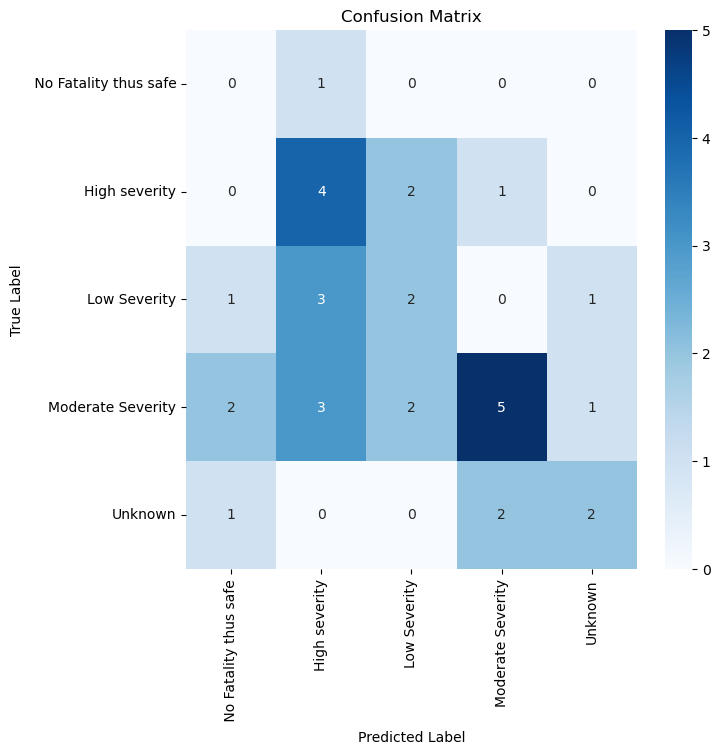

In [43]:
# Data Visualization Confusion Matrix
plt.figure(figsize=(16,7))

# Confusion Matrix
plt.subplot(1,2,1)
sns.heatmap(confu_matrix, 
            annot=True,  
            fmt='d',     
            cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')




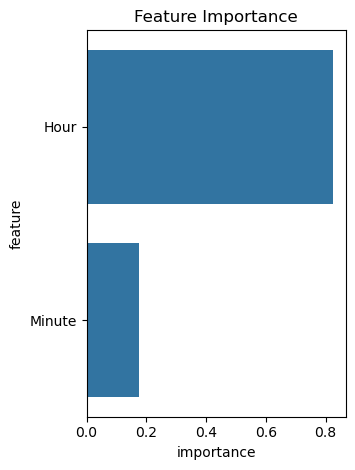

Model Accuracy: 0.39

Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '1': {'precision': 0.5714285714285714, 'recall': 0.36363636363636365, 'f1-score': 0.4444444444444444, 'support': 11.0}, '2': {'precision': 0.2857142857142857, 'recall': 0.3333333333333333, 'f1-score': 0.3076923076923077, 'support': 6.0}, '3': {'precision': 0.38461538461538464, 'recall': 0.625, 'f1-score': 0.47619047619047616, 'support': 8.0}, '4': {'precision': 0.4, 'recall': 0.5, 'f1-score': 0.4444444444444444, 'support': 4.0}, 'accuracy': 0.3939393939393939, 'macro avg': {'precision': 0.3283516483516483, 'recall': 0.3643939393939394, 'f1-score': 0.3345543345543346, 'support': 33.0}, 'weighted avg': {'precision': 0.38414918414918414, 'recall': 0.3939393939393939, 'f1-score': 0.3734043734043734, 'support': 33.0}}

Cross-validation scores: [0.29411765 0.5625     0.25       0.3125     0.1875    ]
Average CV Score: 0.32 (+/- 0.26)


In [44]:
#FEATURE IMPORTANCE BAR CHART.
plt.subplot(1, 2, 2)
importance = pd.DataFrame({
    'feature': ['Hour', 'Minute'],
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=importance, x='importance', y='feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

# Print metrics
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV Score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")



In [45]:
import json
import joblib
import pickle

# Save model parameters
model_params = {
    'n_estimators': model.n_estimators,
    'random_state': model.random_state,
    'max_depth': model.max_depth if hasattr(model, 'max_depth') else None,
    # Add other relevant parameters
}

# Save parameters as JSON
with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

# Save class names
joblib.dump(class_names, 'class_names.joblib', protocol=pickle.HIGHEST_PROTOCOL)

# Save model state with highest protocol for better compatibility
joblib.dump(model, 'accident_severity_model.joblib', protocol=pickle.HIGHEST_PROTOCOL)

['accident_severity_model.joblib']